## 1. Data Trainning
- Data: IRIS
- L = 3
- Feature = 4
- Sample = 50/class

In [108]:
from sklearn import datasets
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

# Load the IRIS dataset
cancer = datasets.load_breast_cancer()
X = cancer.data
y = cancer.target

# Shuffle the dataset
np.random.seed(43)
shuffled_indices = np.random.permutation(X.shape[0])
X = X[shuffled_indices]
y = y[shuffled_indices]

# PCA
pca = PCA(n_components=4)
X = pca.fit_transform(X)

# Scale Minmaxscaler to [0, π]
scaler = MinMaxScaler(feature_range=(0, 2 * np.pi))
X = scaler.fit_transform(X)



# Select 100 samples from each class (class 0, 1)
samples_per_class = 100
selected_indices = np.hstack([
    np.where(y == class_idx)[0][:samples_per_class] for class_idx in range(2)
])

X_selected = X[selected_indices]
y_selected = y[selected_indices]

print(f"Selected X shape: {X_selected.shape}")
print(f"Selected y shape: {y_selected.shape}")


# Take 16 samples per class for training
train_samples_per_class = 32
train_indices = np.hstack([
    np.where(y_selected == class_idx)[0][:train_samples_per_class] for class_idx in range(2)
])

X_train = X_selected[train_indices]
y_train = y_selected[train_indices]
y_train = np.where(y_train == 0, -1, 1)

print(f"Training X shape: {X_train.shape}")
print(f"Training y shape: {y_train.shape}")

# Split the remaining data into testing sets
# Get the indices of the remaining samples (not used for training)
remaining_indices = np.setdiff1d(np.arange(X_selected.shape[0]), train_indices)

X_test = X_selected[remaining_indices]
y_test = y_selected[remaining_indices]


print(f"Test X shape: {X_test.shape}")
print(f"Test y shape: {y_test.shape}")




Selected X shape: (200, 4)
Selected y shape: (200,)
Training X shape: (64, 4)
Training y shape: (64,)
Test X shape: (136, 4)
Test y shape: (136,)


In [109]:
# Variable declaration
num_qubits = X_train.shape[1]
depth = 4
num_classes = 2

## 2. Create Trainable Quantum Feature Map (TQFM)

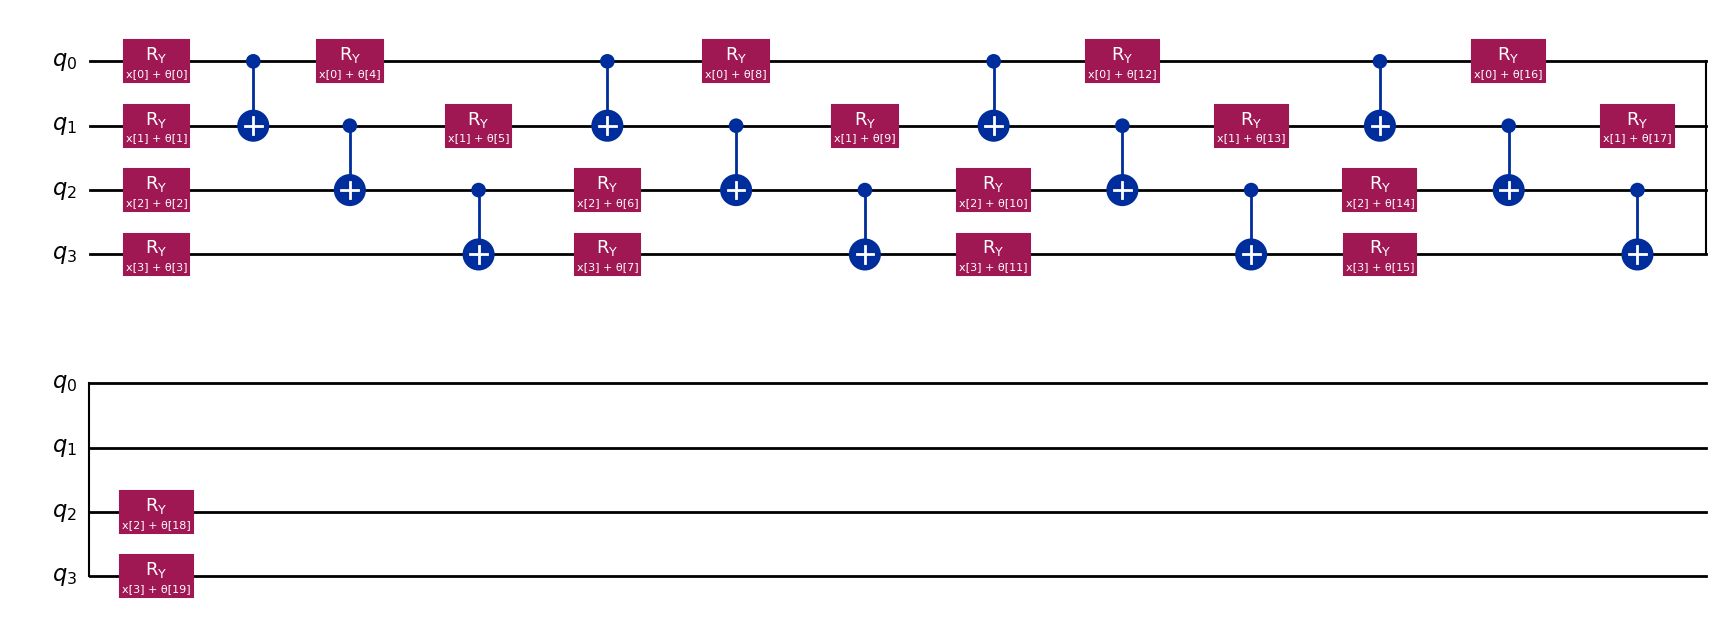

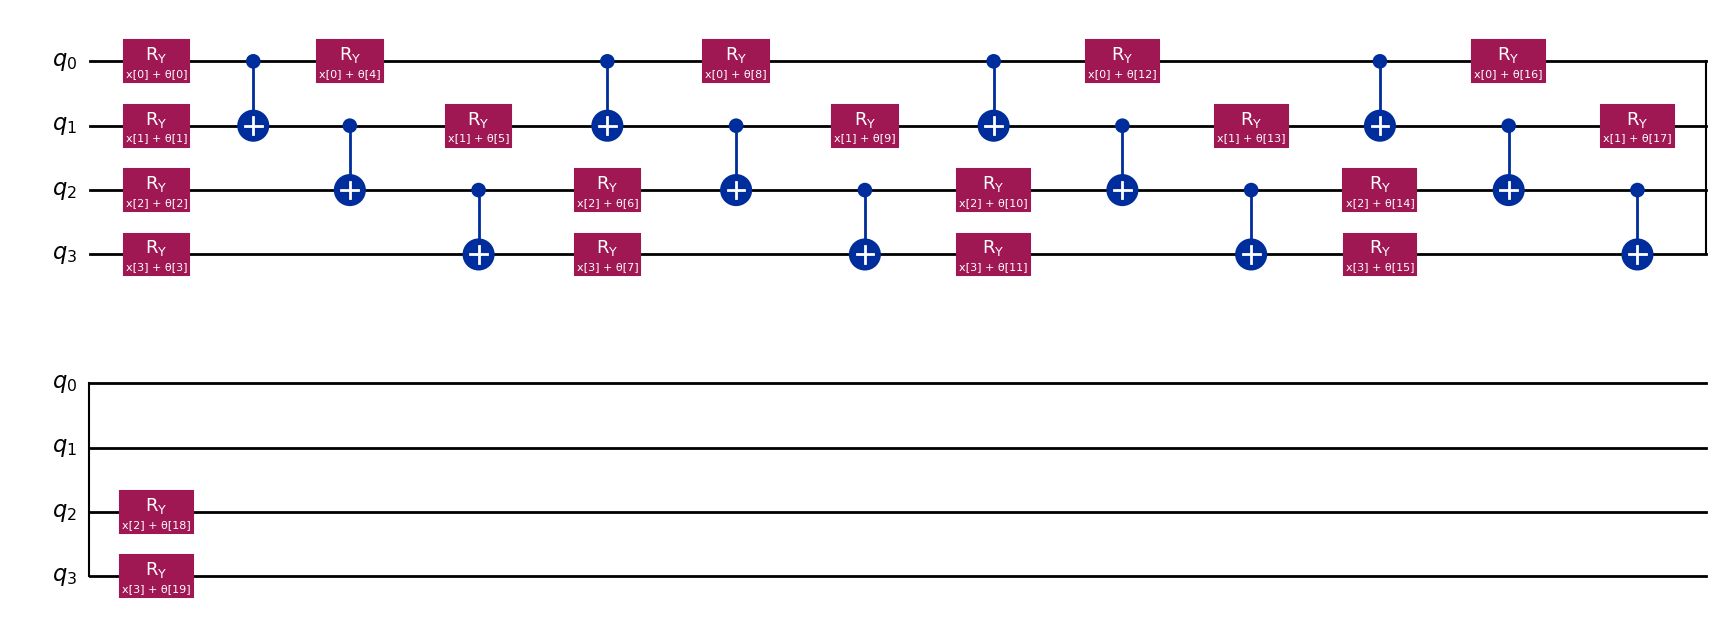

In [110]:
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector

def create_parametrized_circuit(num_qubits, depth):
    """
    Create a parametrized quantum circuit with the given number of qubits and depth.
    
    Args:
        num_qubits (int): Number of qubits in the circuit.
        depth (int): Depth of the circuit (number of layers).
        
    Returns:
        QuantumCircuit: A parametrized quantum circuit.
    """

    qc = QuantumCircuit(num_qubits)
    data = ParameterVector('x', length=num_qubits)
    params = ParameterVector('θ', length=num_qubits * depth * 2)

    # Initial layer
    for i in range(num_qubits):
        qc.ry(data[i] + params[i], i)

    params_index = num_qubits
    # Add layers of entangling gates and parametrized gates
    for layer in range(depth):
        # Apply entangling CNOT gates between adjacent qubits
        for i in range(num_qubits - 1):
            qc.cx(i, i + 1)

        # Apply a layer of parametrized gates
        for i in range(num_qubits):
            qc.ry(data[i] + params[params_index], i)
            params_index += 1
    
    return qc

# Example usage
parametrized_circuit = create_parametrized_circuit(num_qubits, depth)
parametrized_circuit.draw('mpl')
# -*- coding: utf-8 -*-

## 3. Build A Loss Function

$E(\theta) = 1 - \frac{1}{L} \sum_{j=1}^L \frac{1}{M_j} \sum_{i=1}^{M_j} \left|\langle \psi(x_i^j, \theta) \mid y_j \rangle \right|^2$

In [111]:
from qiskit.quantum_info import Statevector
import numpy as np

def loss_function_E(theta, X_data, y_data, circuit_template, num_classes):
    """
    Compute the loss function as defined in the equation:
    E(theta) = 1 - (1/L) * sum_{j=1}^L (1/M_j) * sum_{i=1}^{M_j} |<psi(x_i^j, theta)|y_j>|^2

    Args:
        theta (np.ndarray): Parameters for the quantum circuit.
        X_data (np.ndarray): Input data, shape (N, num_qubits).
        y_data (np.ndarray): Labels, shape (N,). {-1, 1} for binary classification.
        circuit_template (QuantumCircuit): Parametrized quantum circuit.
        num_classes (int): Number of classes.

    Returns:
        float: Loss value.

        example:
        theta = np.random.rand(8)  # Example parameters for depth=1 and num_qubits=4
        loss = loss_function(theta, X_train, y_train, parametrized_circuit, num_classes=2)
        print(f"Loss: {loss}")

    """

    # Convert y_data from {-1, 1} to {0, 1} for indexing
    y_binary = np.where(y_data == -1, 0, 1)
    class_patterns = {0: '00', 1: '01'}
    L = num_classes
    loss = 0.0

    for j in range(L):
        # Select samples of class j
        idx = np.where(y_binary == j)[0]
        M_j = len(idx)
        if M_j == 0:
            continue
        class_loss = 0.0
        for i in idx:
            # Bind data and parameters to the circuit
            param_dict = {}
            # Data parameters
            for k in range(X_data.shape[1]):
                param_dict[circuit_template.parameters[k]] = X_data[i, k]
            # Theta parameters
            theta_params = list(circuit_template.parameters)[X_data.shape[1]:]
            for k, t in enumerate(theta):
                param_dict[theta_params[k]] = t
            # Get statevector
            psi = Statevector.from_instruction(circuit_template.assign_parameters(param_dict))

            #=================================================================#
            if num_qubits > 2:
                prob = 0.0
                pattern = class_patterns[j]
                remaining_qubits = X_data.shape[1] - 2
                # Sum over all possible states for the remaining qubits
                for state_idx in range(2**remaining_qubits):
                    # Create full basis state string
                    remaining_bits = format(state_idx, f'0{remaining_qubits}b')
                    full_state = pattern + remaining_bits
                    
                    # Create basis state and compute probability
                    y_j = Statevector.from_label(full_state)
                    prob += np.abs(np.vdot(psi.data, y_j.data))**2
            else:
                # Create basis state for class j
                pattern = class_patterns[j]
                y_j = Statevector.from_label(pattern)
                prob = np.abs(np.vdot(psi.data, y_j.data))**2
            #================================================================#

            class_loss += prob
        loss += class_loss / M_j
    loss = 1 - (loss / L)
    return loss


# Example usage
theta_example = np.random.rand(len(parametrized_circuit.parameters) - num_qubits) 
loss_example = loss_function_E(theta_example, X_train, y_train, parametrized_circuit, num_classes= num_classes)
print(f"Loss: {loss_example}")


Loss: 0.756053981141466


## 4. Build a optimize function
- COBYLA

In [112]:
from scipy.optimize import minimize

# Create a callback function to monitor optimization progress (optional)
loss_history = []
def callback(theta):
    current_loss = loss_function_E(theta, X_train, y_train, parametrized_circuit, num_classes)
    loss_history.append(current_loss)
    print(f"Loss at iteration {len(loss_history)}: {current_loss}")


# Create a loss function for the quantum circuit
def optimize_cobyla(loss_func, theta_init, X_data, y_data, circuit_template, callback, num_classes):
    """
    Optimize the loss function using COBYLA.

    Args:
        loss_func (callable): The loss function to minimize.
        theta_init (np.ndarray): Initial parameters.
        X_data (np.ndarray): Training data.
        y_data (np.ndarray): Training labels.
        circuit_template (QuantumCircuit): Parametrized quantum circuit.
        num_classes (int): Number of classes.

    Returns:
        OptimizeResult: The result of the optimization.
    """
    result = minimize(
        loss_func,
        theta_init,
        args=(X_data, y_data, circuit_template, num_classes),
        method='COBYLA',
        options={'maxiter': 200},
        callback=callback
    )
    return result

# Example usage:
print("Starting optimization...")
theta_init = np.random.rand(len(parametrized_circuit.parameters) - num_qubits)
result_E = optimize_cobyla(loss_function_E, theta_init, X_train, y_train, parametrized_circuit, callback= callback, num_classes=num_classes)
print("Optimized theta:", result_E.x)
print("Final loss:", result_E.fun)

Starting optimization...
Loss at iteration 1: 0.543555161575144
Loss at iteration 2: 0.5311963652845855
Loss at iteration 3: 0.525841161771485
Loss at iteration 4: 0.525841161771485
Loss at iteration 5: 0.525841161771485
Loss at iteration 6: 0.5107432427983103
Loss at iteration 7: 0.5107432427983103
Loss at iteration 8: 0.5107432427983103
Loss at iteration 9: 0.4862437175864489
Loss at iteration 10: 0.4862437175864489
Loss at iteration 11: 0.4862437175864489
Loss at iteration 12: 0.4542896295097698
Loss at iteration 13: 0.4542896295097698
Loss at iteration 14: 0.4465338820543441
Loss at iteration 15: 0.4465338820543441
Loss at iteration 16: 0.4465338820543441
Loss at iteration 17: 0.4465338820543441
Loss at iteration 18: 0.4354663290636086
Loss at iteration 19: 0.4354663290636086
Loss at iteration 20: 0.4354663290636086
Loss at iteration 21: 0.4354663290636086
Loss at iteration 22: 0.42984975438575934
Loss at iteration 23: 0.42984975438575934
Loss at iteration 24: 0.42984975438575934
L

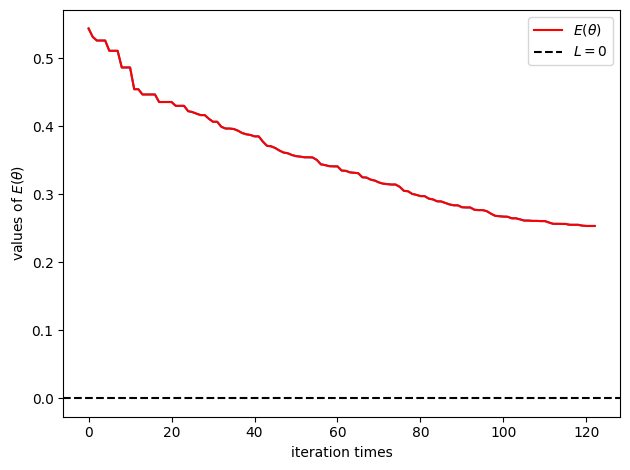

In [113]:
# Plot loss history
import matplotlib.pyplot as plt

plt.plot(loss_history)
plt.xlabel("iteration times")
plt.ylabel(r"values of $E(\theta)$")
plt.plot(loss_history, color='red', label=r"$E(\theta)$")
plt.axhline(0, color='black', linestyle='--', label=r"$L=0$")
plt.legend()
plt.tight_layout()
plt.show()

## 5. Build a function for compute kernel matrix

$$K_{ij} = |<\psi(x_i, \theta)|\psi(x_j, \theta)>|^2$$


In [114]:
def compute_kernel_matrix(X_data, circuit_template, theta_params):
    """
    Compute the kernel matrix K_ij = |<psi(x_i, theta)|psi(x_j, theta)>|^2
    """
    n_samples = X_data.shape[0]
    kernel_matrix = np.zeros((n_samples, n_samples))
    for i in range(n_samples):
        for j in range(n_samples):
            # Prepare statevector for x_i
            param_dict_i = {}
            for k in range(X_data.shape[1]):
                param_dict_i[circuit_template.parameters[k]] = X_data[i, k]
            theta_params_list = list(circuit_template.parameters)[X_data.shape[1]:]
            for k, t in enumerate(theta_params):
                param_dict_i[theta_params_list[k]] = t
            sv_i = Statevector.from_instruction(circuit_template.assign_parameters(param_dict_i))

            # Prepare statevector for x_j
            param_dict_j = {}
            for k in range(X_data.shape[1]):
                param_dict_j[circuit_template.parameters[k]] = X_data[j, k]
            for k, t in enumerate(theta_params):
                param_dict_j[theta_params_list[k]] = t
            sv_j = Statevector.from_instruction(circuit_template.assign_parameters(param_dict_j))

            # Compute squared overlap
            kernel_matrix[i, j] = np.abs(np.vdot(sv_i.data, sv_j.data))**2
    return kernel_matrix

# Kernel matrix before training
kernel_before = compute_kernel_matrix(X_train, parametrized_circuit, theta_init)

# Kernel matrix after training
kernel_after = compute_kernel_matrix(X_train, parametrized_circuit, result_E.x)

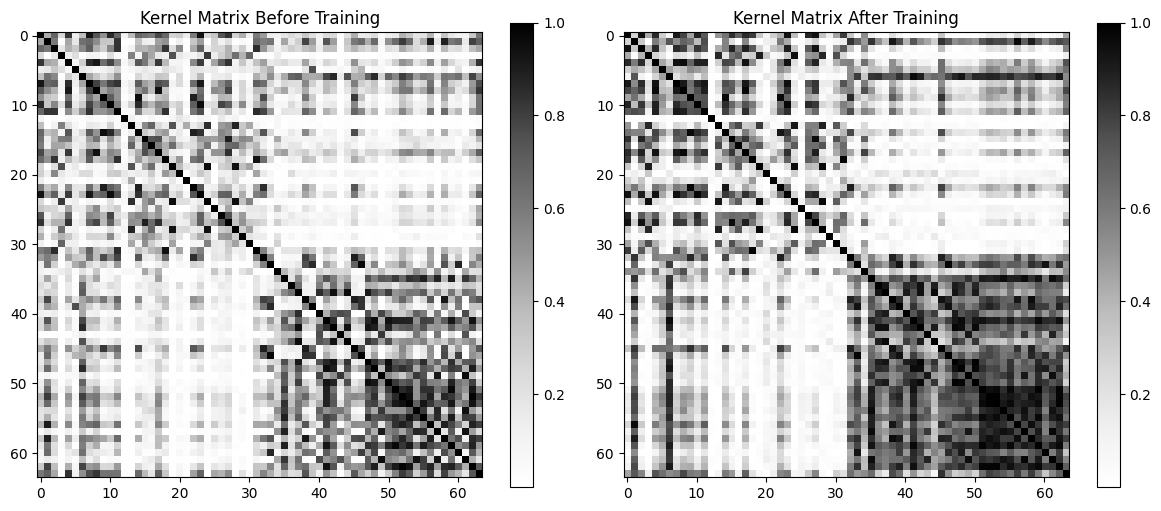

In [115]:
# Plot the kernel matrices
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
im0 = axs[0].imshow(kernel_before, cmap='Greys')
axs[0].set_title("Kernel Matrix Before Training")
plt.colorbar(im0, ax=axs[0])
im1 = axs[1].imshow(kernel_after, cmap='Greys')
axs[1].set_title("Kernel Matrix After Training")
plt.colorbar(im1, ax=axs[1])
plt.tight_layout()
plt.show()


## 6. Define K
$$ K_{ij} = y_iy_j k(x_i, x_j) + δ_{ij}/γ $$

- $k(x_i, x_j)$ is kernel matrix

In [116]:
K = np.zeros_like(kernel_after)

for i in range(kernel_after.shape[0]):
    for j in range(kernel_after.shape[1]):
        K[i, j] = y_train[i] * y_train[j] * kernel_after[i, j] + (1 if i == j else 0) / 1  # Assuming gamma=0.1



## 7. Decomposing Kernel Matrix to Pauli Matrix by using Ramdom Sampling

$$
K=\sum_{(i)} K_{x^{(i)},y^{(i)}} \sum_{j^{(i)}} \frac{1}{2^{M}}\,\sigma_{j}{(i)}
$$


In [117]:
# --- Pauli matrices ---
paulis = {
    "I": np.array([[1, 0],[0, 1]], dtype=complex),
    "X": np.array([[0, 1],[1, 0]], dtype=complex),
    "Y": np.array([[0, -1j],[1j, 0]], dtype=complex),
    "Z": np.array([[1, 0],[0, -1]], dtype=complex),
}

# Projectors in Pauli basis
projector_decomp = {
    (0,0): [("I",0.5), ("Z",0.5)],
    (1,1): [("I",0.5), ("Z",-0.5)],
    (0,1): [("X",0.5), ("Y",0.5j)],
    (1,0): [("X",0.5), ("Y",-0.5j)],
}

# Expand |x><y| to Pauli decomposition
def expand_projector(x_bits, y_bits):
    terms = [([], 1.0)]
    for xb, yb in zip(x_bits, y_bits):
        local_terms = projector_decomp[(xb, yb)]
        new_terms = []
        for prefix, coeff in terms:
            for (p, c) in local_terms:
                new_terms.append((prefix+[p], coeff*c))
        terms = new_terms
    return ["".join(p) for p,c in terms], [c for p,c in terms]

# Example run
expand_projector([1, 1], [0, 1])

(['XI', 'XZ', 'YI', 'YZ'], [0.25, -0.25, -0.25j, 0.25j])

In [118]:

# Random sampling
def random_sampling_pauli(K, num_samples=1000):
    n = int(np.log2(K.shape[0]))
    coeffs = {}

    # Collect nonzero entries
    entries = []
    for i in range(K.shape[0]):
        for j in range(K.shape[1]):
            if abs(K[i,j]) > 1e-12:
                entries.append((i,j,K[i,j]))

    # Probability ∝ |K_ij|
    probs = np.array([abs(v) for _,_,v in entries])
    probs /= probs.sum()

    for _ in range(num_samples):
        # Sample entry (i,j)
        idx = np.random.choice(len(entries), p=probs)
        i,j,val = entries[idx]

        # Binary expansion of i,j
        xi = [int(b) for b in format(i, f"0{n}b")]
        yj = [int(b) for b in format(j, f"0{n}b")]

        # Decompose |xi><yj|
        p_strings, p_coeffs = expand_projector(xi,yj)

        # Sample a Pauli term from this decomposition
        k = np.random.randint(len(p_strings))
        pauli = p_strings[k]
        coeff = val * p_coeffs[k]

        coeffs[pauli] = coeffs.get(pauli, 0) + coeff

    return coeffs



In [119]:
from qiskit.quantum_info import SparsePauliOp

coefficients = random_sampling_pauli(K, num_samples=200)

pauli_matrix = SparsePauliOp.from_list([(pauli_str, coeff) for pauli_str, coeff in coefficients.items() if coeff != 0])

print(f"Pauli matrix: {pauli_matrix}")


Pauli matrix: SparsePauliOp(['ZZIZXI', 'XXYXII', 'XIXXXY', 'ZYYZZX', 'IXIIIY', 'IIZIXY', 'IIXXXZ', 'YYYIII', 'IIXZXZ', 'IZYXYX', 'ZXYIXX', 'IIXYIX', 'ZZIZYI', 'ZIYYIY', 'ZXZZZZ', 'YZIYXI', 'ZYXXIZ', 'IZXIZI', 'ZZZIIZ', 'ZXZIYX', 'IIYYYI', 'XZZZZY', 'YZIZZX', 'ZIXXIY', 'IZYYII', 'IZXZXX', 'ZIIZII', 'IYIZZZ', 'IYIIXZ', 'XXXYXX', 'XIIZII', 'IYXIXY', 'YYZZXX', 'IYIYIY', 'IIIXYZ', 'IIXYYZ', 'YIXYII', 'XZIYXI', 'YYZXZY', 'ZYXXYX', 'IZIIZZ', 'ZZIIXI', 'ZIIXZY', 'IIIZZY', 'YIYZIX', 'IXXZIX', 'ZYYYYZ', 'YZZYXI', 'ZYZIII', 'IXZXXY', 'YXXXZI', 'ZXYYYY', 'ZXIYXZ', 'ZXIYYZ', 'ZXZYZI', 'IXYZZX', 'IIIZII', 'ZYZIXZ', 'ZIYXZZ', 'IZYYXZ', 'ZIIYII', 'IXYZIZ', 'YXXXIX', 'IYZIIX', 'ZYZXYY', 'ZYYZZI', 'XZZYZZ', 'ZYZZXX', 'ZXIIYY', 'XYZIXY', 'YYYYIX', 'IZXXXZ', 'ZXZIZZ', 'IXIIIZ', 'ZXZXIX', 'ZZYIZI', 'XYXIIZ', 'IZYIII', 'YZZXIZ', 'IIZYXX', 'ZZYXIY', 'XYYXYY', 'ZIIZYY', 'XXIIYI', 'IYZZZZ', 'IYXXZZ', 'IXZYYI', 'IXYIYI', 'ZXXZYI', 'IYZIXZ', 'YYZIYY', 'IYYYYY', 'IZXZZZ', 'ZIZIYI', 'IXXXYY', 'ZIYIXY', 'ZXZXIY', '

## 8. Optimize Loss Function

$$L(\alpha) = \min_{\alpha} \frac{1}{2}\langle\alpha|K|\alpha\rangle - || | \alpha \rangle||_1 + Cl^2(\alpha),$$


In [120]:
from scipy.optimize import minimize
from qiskit.quantum_info import Statevector
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
import numpy as np

class VQEplus:
    """
    Custom Variational Quantum Eigensolver (VQE) implementation and extension.

    L(\alpha) = \min_{\alpha} \frac{1}{2}\langle\alpha|K|\alpha\rangle - || | \alpha \rangle||_1 + Cl^2(\alpha)
    
    This class minimizes the loss funtion to find the optimal state vector alpha by using VQE algorithm and Hadamard Test.
    """

    def __init__(self, num_qubit_in_ansatz, ansatz, simulator, transpile, optimizer='COBYLA', initial_point=None, max_iter=100):
        """
        Initialize the VQEplus instance.
        
        Args:
            num_qubit_in_ansatz (int): Number of qubits in the ansatz
            ansatz (QuantumCircuit): Parametrized quantum circuit
            simulator (BaseBackend): Quantum simulator backend
            transpile (callable): Function to transpile circuits
            optimizer (str): Optimization method ('COBYLA', 'BFGS', 'Powell')
            initial_point (np.array): Initial parameter values
            max_iter (int): Maximum number of optimization iterations
        """
        self.m = num_qubit_in_ansatz
        self.ansatz = ansatz
        self.simulator = simulator
        self.transpile = transpile
        self.optimizer = optimizer
        self.initial_point = initial_point
        self.max_iter = max_iter
        self.loss_history = []
        self.optimal_params = None
        self.optimal_value = None
        self.C = 1.0


    def _hadamard_test_circuit(self, bound_circuit, with_cz=False):
        """
        Create a Hadamard test circuit.
        """

        # Create registers
        anc = QuantumRegister(1, 'ancilla')
        data = QuantumRegister(self.m, 'data')
        cr = ClassicalRegister(1, 'measure')
        qc = QuantumCircuit(anc, data, cr)

        bound_circuit = bound_circuit

        # Hadamard on ancillary
        qc.h(anc[0])

        controlled_ansatz = bound_circuit.to_gate().control(1)
        qc.append(controlled_ansatz, [anc[0]] + list(range(1, 1 + self.m)))

        # Apply H ⊗ m on data qubits
        for i in range(self.m):
            qc.h(data[i])

        # Optional controlled-Z for l(α)
        if with_cz:
            qc.cz(anc[0], data[0])  # Control on anc, target on first data qubit (Z_1)

        # Final Hadamard on ancillary    
        qc.h(anc[0])
        qc.measure(anc[0], cr[0])

        return qc

    def _compute_expectation(self, bound_circuit, hamiltonian):
        """
        Compute the expectation value <ψ(θ)|H|ψ(θ)>
        
        Args:
            statevector (Statevector): Statevector of the quantum state
            hamiltonian (SparsePauliOp): Observable operator
            
        Returns:
            float: Expectation value
        """
            
        try:
            statevector = Statevector.from_instruction(bound_circuit)
            expectation = statevector.expectation_value(hamiltonian).real
        except Exception as e:
            print(f"Error computing expectation value: {e}")
            return 0.0

        return expectation
            
    

    def _compute_l1_norm(self, qc_template):
        """
        Compute the L1 norm || |α> ||_1 = (P0 - P1) * √2^m
        """

        transpiled_qc = self.transpile(qc_template, self.simulator)
        
        try:
            job = self.simulator.run(transpiled_qc, shots=4096)
            result = job.result()
            counts = result.get_counts()
            prob_0 = counts.get('0', 0) / 4096
            prob_1 = counts.get('1', 0) / 4096
        except Exception as e:
            print(f"Simulation error: {e}")
            return 0.0
        
        # Estimate ||α||_1 (approximate)
        l1_norm = (prob_0 - prob_1) * np.sqrt(2 ** self.m)

        return l1_norm

    
    def _compute_l_alpha(self, qc_template):
        """
        Compute l(α) = (P0 - P1) * √2^m
        """


        transpiled_qc = self.transpile(qc_template, self.simulator)

        try:
            job = self.simulator.run(transpiled_qc, shots=4096)
            result = job.result()
            counts = result.get_counts()
            prob_0 = counts.get('0', 0) / 4096
            prob_1 = counts.get('1', 0) / 4096
        except Exception as e: 
            print(f"Simulation error: {e}")
            return 0.0
        
        # Estimate l(α) (approximate)
        l_alpha = (prob_0 - prob_1) * np.sqrt(2 ** self.m)

        return l_alpha

        
    def _loss_function(self, theta, hamiltonian):
        """
        Compute the loss function
        
        Args:
            theta (np.array): Parameter values
            hamiltonian (SparsePauliOp): Observable operator

        Returns:
            float: Loss value
        """
        try:
            param_dict = {param: theta[i] for i, param in enumerate(self.ansatz.parameters)}
            bound_circuit = self.ansatz.assign_parameters(param_dict)

            # Compute expectation value
            expectation = self._compute_expectation(bound_circuit, hamiltonian)

            # Compute || |α> ||_1
            qc_2 = self._hadamard_test_circuit(bound_circuit, with_cz=False)
            l1_norm = self._compute_l1_norm(qc_2)

            # Compute l(α)
            qc_3 = self._hadamard_test_circuit(bound_circuit, with_cz=True)
            l_alpha = self._compute_l_alpha(qc_3)

            # Compute L(α)
            loss = 0.5 * expectation - l1_norm + self.C * (l_alpha ** 2)

            # Store loss history
            self.loss_history.append(loss)

            return loss

        except Exception as e:
            print(f"Error in cost function: {e}")
            return float('inf')


    def compute_minimum_loss(self, hamiltonian):
        """
        Find the minimum Loss.

        Args:
            hamiltonian (SparsePauliOp): The Hamiltonian operator

        Returns:
            dict: Results containing optimal_value, optimal_point, success, etc.
        """
        # Get number of parameters
        num_params = len(self.ansatz.parameters)

        # Set initial point if not provided
        if self.initial_point is None:
            self.initial_point = np.random.uniform(0, 2*np.pi, num_params)

        # Clear previous history
        self.loss_history = []

        # Define optimization options
        options = {'maxiter': self.max_iter}
        if self.optimizer == 'COBYLA':
            options['disp'] = True

        # Perform optimization
        result = minimize(
            fun=self._loss_function,
            x0=self.initial_point,
            args=(hamiltonian,),
            method=self.optimizer,
            options=options
        )

        # Store results
        self.optimal_params = result.x
        self.optimal_value = result.fun

        # Return VQE-style result
        return {
            'optimal_value': result.fun,
            'optimal_point': result.x,
            'success': result.success,
            'nfev': result.nfev,
            'cost_history': self.loss_history.copy(),
            'message': result.message
        }

    def get_optimal_circuit(self):
        """
        Get the quantum circuit with optimal parameters bound.

        Returns:
            QuantumCircuit: Circuit with optimal parameters
        """
        if self.optimal_params is None:
            raise ValueError("Must run compute_minimum_loss first!")

        param_dict = {param: self.optimal_params[i] 
                     for i, param in enumerate(self.ansatz.parameters)}
        return self.ansatz.assign_parameters(param_dict)


    
    def plot_convergence(self):
        """
        Plot the convergence of the loss function.
        """
        import matplotlib.pyplot as plt

        if not self.loss_history:
            print("No optimization history available. Run compute_minimum_loss first.")
            return
            
        plt.figure(figsize=(10, 6))
        plt.plot(self.loss_history, 'b-', linewidth=2)
        plt.xlabel('Iteration')
        plt.ylabel('Loss Function Value')
        plt.title('VQEplus Convergence')
        plt.grid(True)
        plt.show()


<>:7: SyntaxWarning: invalid escape sequence '\m'
<>:7: SyntaxWarning: invalid escape sequence '\m'
C:\Users\Nguyen Dinh Quyen\AppData\Local\Temp\ipykernel_23348\1359962385.py:7: SyntaxWarning: invalid escape sequence '\m'
  """


In [121]:
# m = log2(M)
m = int(np.ceil(np.log2(len(X_train))))
print(f"m: {m}")

m: 6


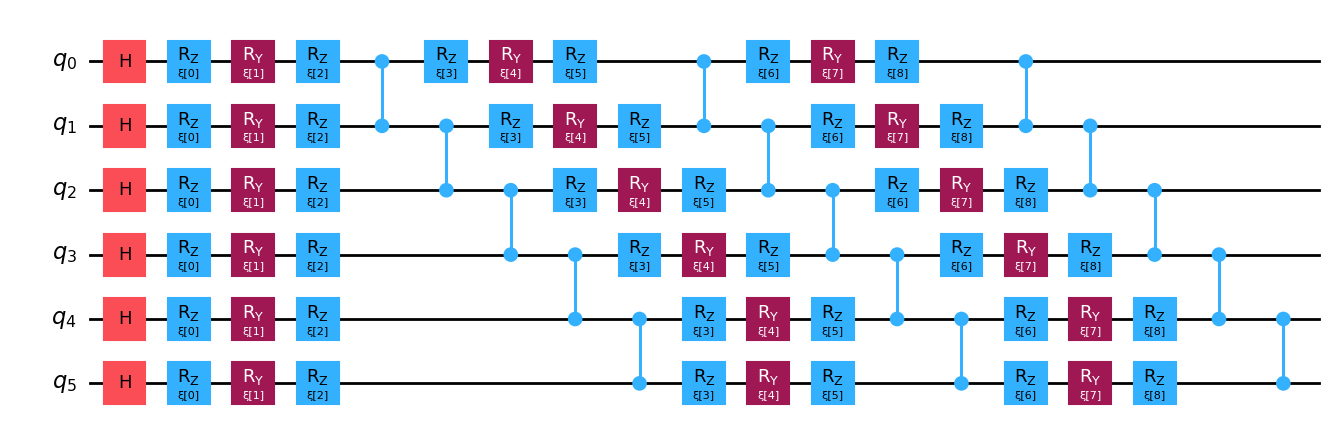

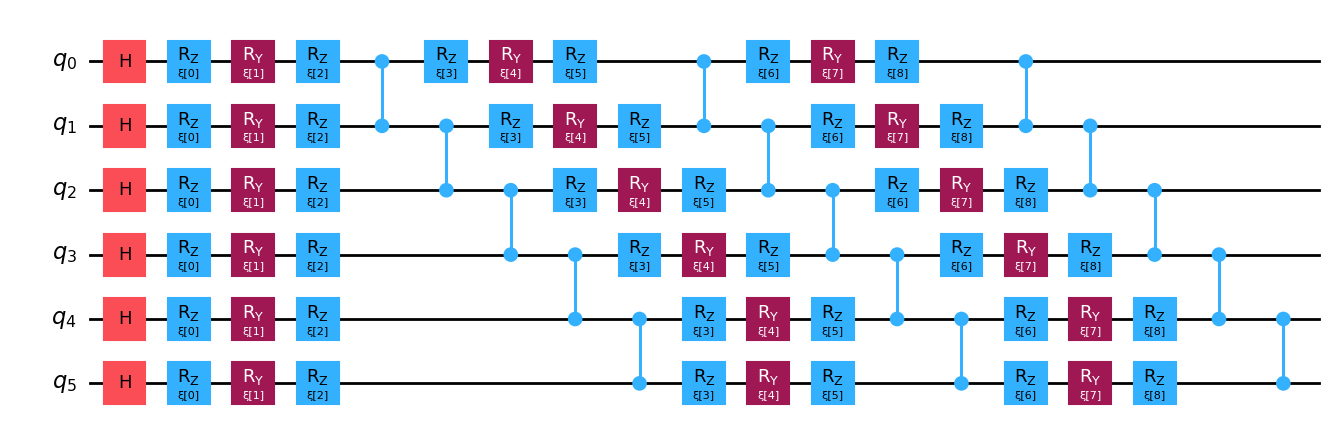

In [122]:
from qiskit.circuit import Parameter


# Create ansatz function complex more parameters
def create_ansatz_complex(num_qubits, thetas):
    ansatz = QuantumCircuit(num_qubits, name='Ansatz')
    for i in range(num_qubits):
        ansatz.h(i)

    param_idx = 0
    for layer in range(3):
        for i in range(num_qubits):
            ansatz.rz(thetas[param_idx], i)
        param_idx += 1
        for i in range(num_qubits):
            ansatz.ry(thetas[param_idx], i)
        param_idx += 1
        for i in range(num_qubits):
            ansatz.rz(thetas[param_idx], i)
        param_idx += 1
        for i in range(num_qubits - 1):
            ansatz.cz(i, i + 1)
    return ansatz

xi = ParameterVector('ξ', length= 3 * 3)
ansatz = create_ansatz_complex(m, xi)
ansatz.draw('mpl')

In [123]:
from qiskit_aer import AerSimulator
from qiskit import transpile

hamiltonian = pauli_matrix
simulator = AerSimulator(method='density_matrix')

# initial_theta = [2.84743816, 3.23544408, 3.24591203, 4.52856334, 1.7402027, 5.33539224,
#                 3.82424738, 5.32096924, 5.21865859]
vqeplus = VQEplus(m, ansatz, simulator, transpile, optimizer='COBYLA', max_iter=100, initial_point=None)
result_L = vqeplus.compute_minimum_loss(hamiltonian)

print("VQEplus Result:")
print(f"Optimal Value: {result_L['optimal_value']}")
print(f"Optimal Point: {result_L['optimal_point']}")

Return from COBYLA because the trust region radius reaches its lower bound.
Number of function values = 77   Least value of F = -1.0132726656952062
The corresponding X is:
[2.97400271 2.62734706 3.17041845 4.39050211 1.54428925 6.49700464
 3.50720794 5.08178681 5.01043864]

VQEplus Result:
Optimal Value: -1.0132726656952062
Optimal Point: [2.97400271 2.62734706 3.17041845 4.39050211 1.54428925 6.49700464
 3.50720794 5.08178681 5.01043864]


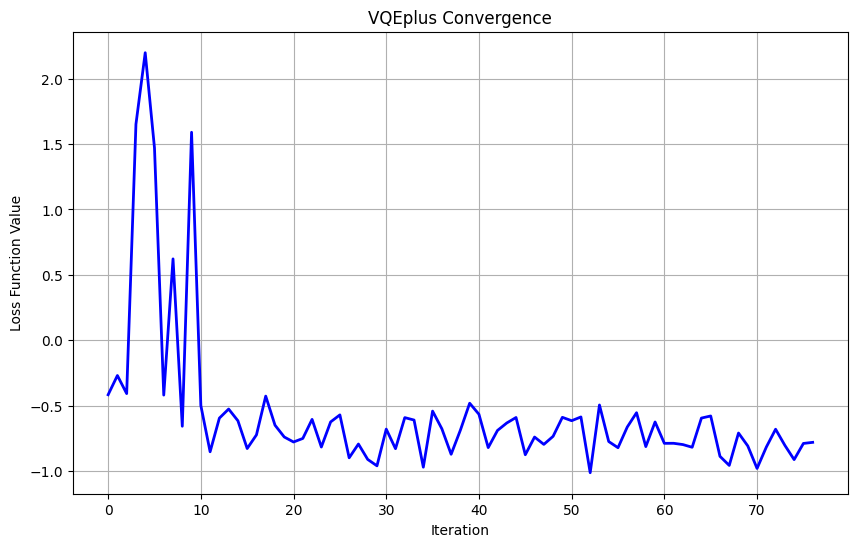

In [124]:
vqeplus.plot_convergence()

## 8. Measure $U_A(\xi^*)$

Measurement results at ξ*: {'000010': 13, '101011': 65, '110101': 78, '000100': 6, '101101': 88, '110011': 157, '111011': 62, '100101': 35, '001110': 135, '011000': 106, '001111': 6, '111010': 28, '100110': 133, '000110': 139, '110001': 44, '101111': 82, '011111': 246, '110000': 127, '000111': 104, '010001': 41, '001100': 20, '100011': 42, '111101': 82, '100010': 53, '001011': 40, '111110': 235, '111000': 113, '010010': 21, '001010': 14, '111111': 17, '100001': 31, '110100': 44, '101100': 69, '000011': 134, '100000': 85, '101010': 13, '000001': 89, '110110': 73, '011100': 121, '110111': 71, '000000': 131, '011001': 152, '010100': 10, '110010': 21, '101110': 10, '000101': 15, '010101': 17, '011010': 127, '011110': 126, '011011': 65, '010110': 120, '001001': 22, '100100': 19, '001101': 75, '111100': 10, '100111': 5, '010011': 14, '101001': 28, '111001': 5, '010111': 15, '101000': 16, '001000': 9, '010000': 16, '011101': 6}


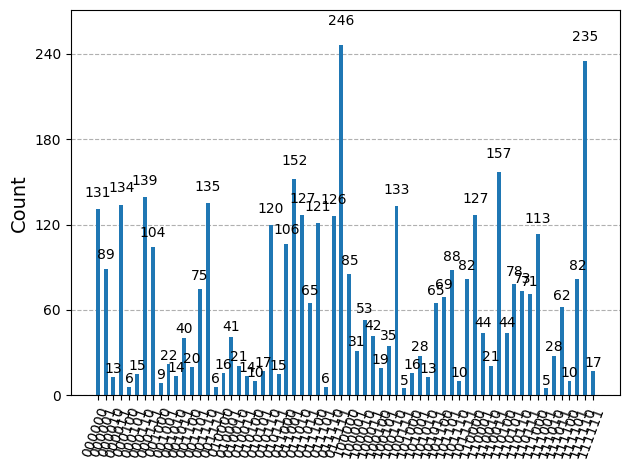

In [125]:
import matplotlib.pyplot as plt
from qiskit.visualization import plot_histogram
# Create ansatz with optimal parameter
xi = ParameterVector('ξ', length= 3 * 3)
ansatz = create_ansatz_complex(m, xi)
ansatz.measure_all()

params = result_L['optimal_point']
# params = [2.84743816, 3.23544408, 3.24591203, 4.52856334, 1.7402027, 5.33539224,
#           3.82424738, 5.32096924, 5.21865859]
ansatz = ansatz.assign_parameters({xi: params})

# Backend simulator
simulator = AerSimulator()
compiled = transpile(ansatz, simulator)
result = simulator.run(compiled, shots=4096).result()
counts = result.get_counts()

# In histogram
print("Measurement results at ξ*:", counts)
%matplotlib inline
plot_histogram(counts)
plt.show()

In [126]:
from qiskit.quantum_info import Statevector

# Create ansatz with optimal parameter
xi = ParameterVector('ξ', length= 3 * 3)
ansatz = create_ansatz_complex(m, xi)

# bound_ansatz = ansatz.assign_parameters({ansatz.parameters[i]: params[i] for i in range(len(params))})

bound_ansatz = ansatz.assign_parameters({xi: params})


state = Statevector.from_instruction(bound_ansatz)
print("Final statevector at ξ*:", state)

Final statevector at ξ*: Statevector([ 1.03303083e-01+0.15483788j, -3.19770601e-02-0.13714747j,
             -9.53519175e-03+0.06495273j, -1.39833077e-01+0.0861599j ,
              2.06493888e-02+0.02409675j,  2.45511311e-02+0.05428774j,
             -1.72944720e-01+0.02614385j,  1.58356724e-01+0.05356166j,
              2.06493888e-02+0.02409675j,  9.56214340e-03+0.06453414j,
             -5.32957690e-02+0.03291047j, -1.99625229e-05-0.10423883j,
             -5.77059149e-02-0.04074022j,  4.25968715e-02-0.11365661j,
              1.34827935e-01+0.12528091j, -3.32323475e-04+0.0395407j ,
             -9.53519175e-03+0.06495273j, -1.11189802e-01-0.03559981j,
             -6.61429427e-02-0.01445184j,  1.36121347e-02+0.06990029j,
             -5.32957690e-02+0.03291047j, -4.66684475e-02+0.03234996j,
              9.46799914e-02-0.14447543j,  6.89661387e-02+0.02717311j,
             -1.72944720e-01+0.02614385j,  1.91992599e-01+0.02026772j,
              9.46799914e-02-0.14447543j, -1.0230626

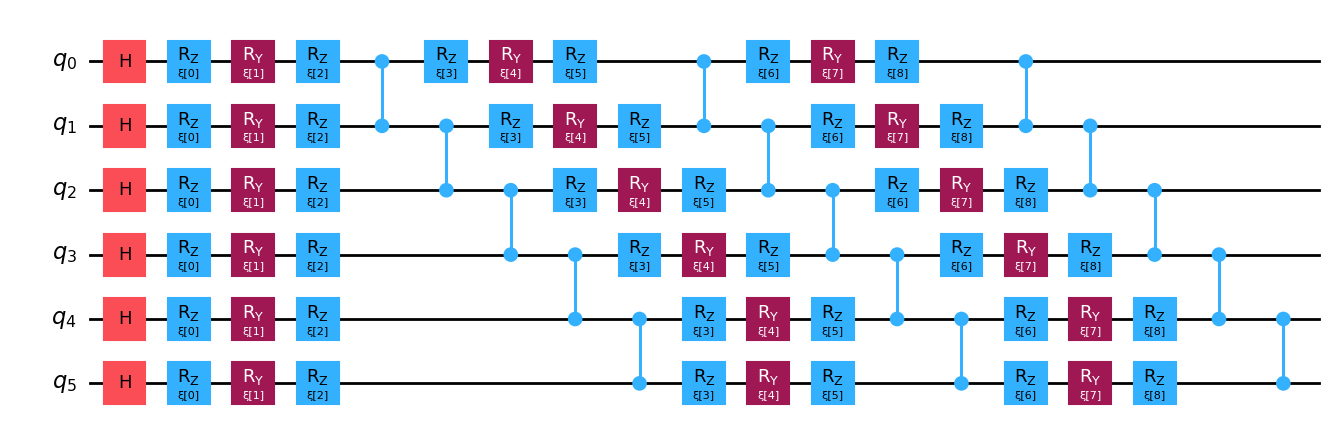

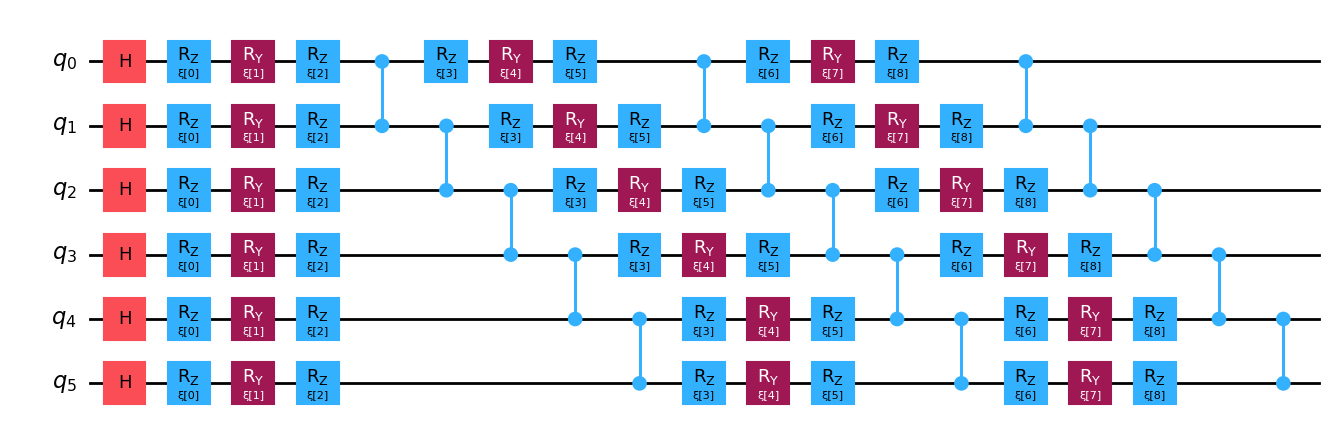

In [135]:
ansatz.draw('mpl')

## 9. Identify c_i

In [127]:
# Identify support vectors based on state vector alpha
def get_support_vectors(state_vector):
    """
    Identify support vectors based on the state vector probabilities.
    """
    max_prob = max(state_vector.probabilities())
    threshold = max_prob * 0.1
    num_qubits = int(np.log2(len(state_vector)))

    support_vectors = []
    c_i = np.zeros(len(state_vector))

    for k, v in enumerate(state_vector.probabilities()):
        bitstring = format(k, f"0{num_qubits}b")
        if v > threshold:
            support_vectors.append(bitstring)
            c_i[k] = 1

    return support_vectors, c_i


sv, c = get_support_vectors(state)

print(f"Support vectors: {sv}")
print(f"c_i values: {c}")
print("Number of support vectors:", len(sv))

Support vectors: ['000000', '000001', '000011', '000110', '000111', '001011', '001101', '001110', '010001', '010110', '011000', '011001', '011010', '011011', '011100', '011110', '011111', '100000', '100001', '100010', '100011', '100101', '100110', '101001', '101011', '101100', '101101', '101111', '110000', '110001', '110011', '110100', '110101', '110110', '110111', '111000', '111011', '111101', '111110']
c_i values: [1. 1. 0. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0.
 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 0. 1. 0. 1. 1. 1. 0. 1.
 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 1. 0. 1. 1. 0.]
Number of support vectors: 39


## 10. Build Decision Function

$$
 y = \operatorname{sgn}(f(x)) 
   = \operatorname{sgn}\!\left( \langle \nu | \mu \rangle \right)
$$

$$
|\mu\rangle 
   = \sum_{i=1}^M \alpha_i y_i c_i \, |i-1\rangle \, |\psi(x_i), \theta^\ast \rangle
$$

$$
|\nu\rangle 
   = \frac{1}{\sqrt{m_s}} 
     \sum_{i=1}^M c_i \, |i-1\rangle \, |\psi(x, \theta^\ast)\rangle.
$$

In [128]:
def basis_strings(n):
    """
    Generate the basis strings for a given number of qubits.

    Args:
        n (int): The number of qubits.

    Returns:
        list: A list of basis strings.
    """
    return [format(i, f"0{n}b") for i in range(2**n)]



In [129]:
def create_psi(x, theta, circuit_template):
    """
    Create the quantum state |psi(x, theta)> for a given input x and parameters theta.

    Args:
        x (np.ndarray): Input feature vector. (1, n)
        theta (np.ndarray): Parameter vector.
        circuit_template (QuantumCircuit): The quantum circuit template.

    Returns:
        Statevector: The resulting quantum statevector.
    """

    param_dict = {}
    x = x.reshape(1, -1)
    
    for k in range(x.shape[1]):
        param_dict[circuit_template.parameters[k]] = x[0, k]
    theta_params_list = list(circuit_template.parameters)[x.shape[1]:]
    for k, t in enumerate(theta):
        param_dict[theta_params_list[k]] = t
    psi = Statevector.from_instruction(circuit_template.assign_parameters(param_dict))

    return psi


In [130]:
# Initialize parameters
a = state.probabilities()
y_labels = y_train  
c_values = c
basis_vectors = basis_strings(m)
state_basis = [Statevector.from_label(bv) for bv in basis_vectors]

ms = len(sv)
M = len(X_train)
theta_optimal = result_E.x

print(f"Number of training samples (M): {M}")
print(f"Number of basis states (2^m): {len(state_basis)}")
print(f"Length of support vectors: {ms}")

# compute mu
mu = 0
for i in range(M):
    mu += a[i] * y_labels[i] * c_values[i] * np.kron(state_basis[i], create_psi(X_train[i], theta_optimal, parametrized_circuit))
print(mu)

# compute nu
nus = []
for x_test in X_test:
    nu = 0
    for i in range(M):
        nu += c_values[i] * np.kron(Statevector.from_label(basis_vectors[i]), create_psi(x_test, theta_optimal, parametrized_circuit))
    nu = nu / np.sqrt(ms)
    nus.append(nu)


# decision
decisions = []
for nu in nus:
    decision = np.sign(np.vdot(mu, nu).real)
    decisions.append(decision)


accuracy = np.mean(np.array(decisions) == np.where(y_test == 0, -1, 1))
print(f"Test set accuracy: {accuracy * 100:.2f}%")



Number of training samples (M): 64
Number of basis states (2^m): 64
Length of support vectors: 39
[0.01230588+0.j 0.0231314 +0.j 0.01336625+0.j ... 0.        +0.j
 0.        +0.j 0.        +0.j]
Test set accuracy: 88.97%


In [155]:
print(sum(mu))

(0.3740126683812913+0j)


In [164]:
print(f"sum(mu): {sum(mu)}")
print(f"sum(nus[1]): {sum(nus[1])}")

sum(mu): (0.3740126683812913+0j)
sum(nus[1]): (-10.339613118821276+0j)


In [151]:
print(create_psi(X_train[0], theta_optimal, parametrized_circuit))

Statevector([-0.35518591+0.j, -0.66764432+0.j, -0.38579174+0.j,
             -0.46927024+0.j,  0.11773465+0.j,  0.06609659+0.j,
              0.08701645+0.j,  0.02910072+0.j,  0.08512315+0.j,
              0.04596916+0.j,  0.02873493+0.j,  0.04795837+0.j,
              0.04999003+0.j, -0.03790711+0.j,  0.12408877+0.j,
              0.02401061+0.j],
            dims=(2, 2, 2, 2))


In [150]:
Statevector.from_label(basis_vectors[2])

Statevector([0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j],
            dims=(2, 2, 2, 2, 2, 2))


In [131]:
decision_list = np.array(decisions).flatten().tolist()
print(decision_list)

[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 1.0, -1.0, -1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 1.0, 1.0, -1.0, -1.0, -1.0, 1.0, 1.0, -1.0, -1.0, -1.0, -1.0, 1.0, 1.0, -1.0, -1.0, -1.0, 1.0, -1.0, -1.0, -1.0, -1.0, 1.0, 1.0, -1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 1.0, 1.0, -1.0, -1.0, -1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [132]:
def compute_kernel_matrix_predict_corrected(X_train, X_test, circuit_template, theta_params):
    """
    Compute the kernel matrix for prediction: K_ij = |<psi(X_test[i], theta)|psi(X_train[j], theta)>|^2
    Returns shape (n_test, n_train) which is correct for sklearn's precomputed kernel format.
    """
    kernel_matrix = np.zeros((X_test.shape[0], X_train.shape[0]))
    
    for i in range(X_test.shape[0]):  # Test samples
        for j in range(X_train.shape[0]):  # Training samples
            # Prepare statevector for test sample x_i
            param_dict_i = {}
            for k in range(X_test.shape[1]):
                param_dict_i[circuit_template.parameters[k]] = X_test[i, k]
            theta_params_list = list(circuit_template.parameters)[X_test.shape[1]:]
            for k, t in enumerate(theta_params):
                param_dict_i[theta_params_list[k]] = t
            sv_i = Statevector.from_instruction(circuit_template.assign_parameters(param_dict_i))

            # Prepare statevector for training sample x_j
            param_dict_j = {}
            for k in range(X_train.shape[1]):
                param_dict_j[circuit_template.parameters[k]] = X_train[j, k]
            for k, t in enumerate(theta_params):
                param_dict_j[theta_params_list[k]] = t
            sv_j = Statevector.from_instruction(circuit_template.assign_parameters(param_dict_j))

            # Compute squared overlap
            kernel_matrix[i, j] = np.abs(np.vdot(sv_i.data, sv_j.data))**2
            
    return kernel_matrix

In [133]:
from sklearn.svm import SVC


svm2 = SVC(kernel='precomputed', C=1/0.01)
svm2.fit(kernel_after, y_train)

# Use the corrected function that returns (n_test, n_train) directly
K_test_corrected = compute_kernel_matrix_predict_corrected(X_train, X_test, parametrized_circuit, result_E.x)

print(f"Training kernel shape: {kernel_after.shape}")
print(f"Test kernel shape (corrected): {K_test_corrected.shape}")

y_pred_svm2 = svm2.predict(K_test_corrected)
accuracy_svm2 = np.mean(y_pred_svm2 == np.where(y_test == 0, -1, 1))
print(f"SVM Test set accuracy (corrected): {accuracy_svm2 * 100:.2f}%")

Training kernel shape: (64, 64)
Test kernel shape (corrected): (136, 64)
SVM Test set accuracy (corrected): 91.18%


In [134]:
# 5. Lấy alpha_i
alphas = np.zeros(len(y_train))
support_indices = svm2.support_
dual_coefs = svm2.dual_coef_.ravel()  # = alpha_i * y_i

# Tính alpha_i = dual_coef / y_i
alphas[support_indices] = dual_coefs / y_train[support_indices]

print("Support vector indices:", support_indices)
print("Alpha_i (khác 0 ở support vectors):")
print(alphas)

Support vector indices: [ 1  5  6 12 15 22 30 32 34 36 42 54 56]
Alpha_i (khác 0 ở support vectors):
[ 0.         85.20721877  0.          0.          0.          2.21196403
 26.26984253  0.          0.          0.          0.          0.
  0.92680037  0.          0.          2.92126764  0.          0.
  0.          0.          0.          0.         32.31832207  0.
  0.          0.          0.          0.          0.          0.
  1.74489212  0.         59.86899801  0.          7.82096174  0.
 16.57611198  0.          0.          0.          0.          0.
  4.64995258  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  4.02970944  0.         58.65457379  0.          0.          0.
  0.          0.          0.          0.        ]
